In [1]:
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot

In [2]:
# load dataset
def parser(x):
    #print(x)
    #raise
    return datetime.strptime('190'+x, '%Y-%m')

series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
#series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
#print(series)
#series[-1]
print(series)

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales of shampoo over a three year period, dtype: float64


In [3]:
series.dtypes

dtype('float64')

In [4]:
series.describe()

count     36.000000
mean     312.600000
std      148.937164
min      119.300000
25%      192.450000
50%      280.150000
75%      411.100000
max      682.000000
Name: Sales of shampoo over a three year period, dtype: float64

In [5]:
# split data into train and test
X = series.values
train, test = X[0:-12], X[-12:]

In [6]:
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# line plot of observed vs predicted

RMSE: 136.761


Baseline model:

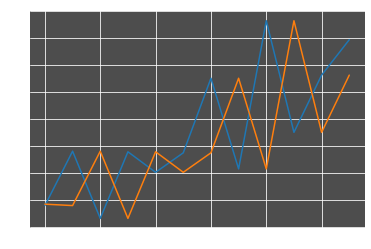

In [7]:
pyplot.plot(test)
pyplot.plot(predictions)
pyplot.show()

Helper function

In [8]:
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

Convert to time shifted dataframe

In [10]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df
 
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# transform to supervised learning
X = series.values
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())
#supervised

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


In [11]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [12]:
from pandas import read_csv
from pandas import datetime
from pandas import Series

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]



Testing the difference

In [13]:
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform to be stationary
differenced = difference(series, 1)
print(differenced.head())
# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = Series(inverted)
print(inverted.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


In [14]:
from pandas import read_csv
from pandas import datetime
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
# transform scale
X = series.values
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)
scaled_series = Series(scaled_X[:, 0])
print(scaled_series.head())
# invert transform
inverted_X = scaler.inverse_transform(scaled_X)
inverted_series = Series(inverted_X[:, 0])
print(inverted_series.head())

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64
0   -0.478585
1   -0.905456
2   -0.773236
3   -1.000000
4   -0.783188
dtype: float64
0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64
